In [1]:

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time
import random
import scipy.stats as stats
from scipy.sparse import *
from mainSVT import *
from visualizingData import *
import pandas as pd
import os
import ast


In [2]:
# Load the data from the specified .npz file
file = np.load("..\\..\\data_manip\\provided_data\\QTOF.npz", allow_pickle=True)

# # Extract the necessary components from the file
print(file.files)

selected_B = file['selected_B'][()]
shape = file['shape'][()]
mz_values = file['mz'][()]

ground_truth = selected_B


['selected_B', 'shape', 'mz']


In [3]:
selected_B.shape
selected_B = selected_B.toarray()
mask = np.where(selected_B==0,0,1)

In [4]:
selected_B.shape

(312249, 1600)

In [5]:
DENSE, MASK = selected_B , mask


DENSE, MASK = sample_array_with_mask(DENSE,MASK,100000 )


In [6]:
import time
from scipy.sparse.linalg import svds
from scipy.linalg import norm
import numpy as np

In [7]:

def svt(data_matrix, step_size, tolerance, tau, max_iter, mask, max_rank=10):
    t = time.time()
    # Initialize k and a Y_0
    k = 1
    Y_0 = k_0_finder(tau, step_size, data_matrix*mask) * step_size * data_matrix*mask
    
    # Tracking variables
    rank_arr = []
    rel_error_s_arr = []

    # Iterative SVT
    Y = Y_0
    print(f'Y_0 maken duurde {time.time()-t} s')
    print('Starting up...')
    
    for k in range(1, max_iter + 1):
        # Compute top singular values/vectors using sparse SVD
        U, sigma, Vt = svd(Y,full_matrices=False)
        print(f'sigma = {sigma[:3]}')
        
        # Thresholding singular values
        sigma_thresh = np.maximum(sigma - tau, 0)
        rank = np.sum(sigma_thresh > 0)

        # Construct the low-rank approximation
        X = U[:, :rank] @ np.diag(sigma_thresh[:rank]) @ Vt[:rank, :]


        # Calculate relative error
        error_sampled_matrix = mask *(data_matrix - X)
        
        rel_insampling, rel_outsampling, rel_gen_err = allErrors(data_matrix, X,mask)
        r_err_stop = np.sqrt(rel_insampling/100)
        
        # Adjust step size for stability
        if r_err_stop < 1e-2:
            step_size *= 0.9
        
        # Update Y
        Y += step_size * error_sampled_matrix

        # Store metrics
        rank_arr.append(rank)
        rel_error_s_arr.append([rel_insampling, rel_outsampling, rel_gen_err])

        # Print iteration details
        print(f'Iter {k};')
        print(f'IS={rel_insampling}; OS={rel_outsampling}; GE={rel_gen_err}')
        print('Rank:', rank)
        print()

        # Check stopping conditions
        if rank > max_rank or r_err_stop < tolerance or suggested_stop(X, data_matrix, tolerance):
            break
    
    return X, rank_arr, k, rel_error_s_arr


In [8]:
DENSE.shape

(100000, 1600)

In [9]:


# Parameters for SVT
step_size = 1.2
tolerance = 1e-4
tau = 1*(max(DENSE.shape))
max_iter = 500
max_rank = min(DENSE.shape)//10


# Run SVT
X, rank_arr, num_iters, rel_errors = svt(DENSE, step_size, tolerance, tau, max_iter,MASK, max_rank)
print("Final rank:", rank_arr[-1])
print("Number of iterations:", num_iters)


Y_0 maken duurde 25.669208526611328 s
Starting up...
sigma = [464793.00979117 227588.48512575  48659.59383314]
Iter 1;
IS=10.956504183863904; OS=0.6553661685332032; GE=11.61187035239715
Rank: 2

sigma = [497414.36380296 301408.92826657  96707.03926285]
Iter 2;
IS=8.273635850213225; OS=1.6124679240145732; GE=9.886103774227767
Rank: 2

sigma = [494331.33370934 288742.86741833 144557.72266459]
Iter 3;
IS=6.414979446991537; OS=2.4672582846646205; GE=8.882237731656149
Rank: 5

sigma = [498057.4365957  291661.75616161 139902.06648311]
Iter 4;
IS=5.3877998524110575; OS=3.2915771469776636; GE=8.679376999388715
Rank: 7

sigma = [500000.93675926 291651.84115817 140737.88839858]
Iter 5;
IS=4.847696782752873; OS=4.035042971390198; GE=8.88273975414306
Rank: 9

sigma = [501985.34380506 292086.39900855 140518.20886619]
Iter 6;
IS=4.517214942976108; OS=4.718208239266473; GE=9.235423182242537
Rank: 11

sigma = [503693.37609888 292403.42265027 140495.42533311]
Iter 7;
IS=4.305499471844971; OS=5.34131477

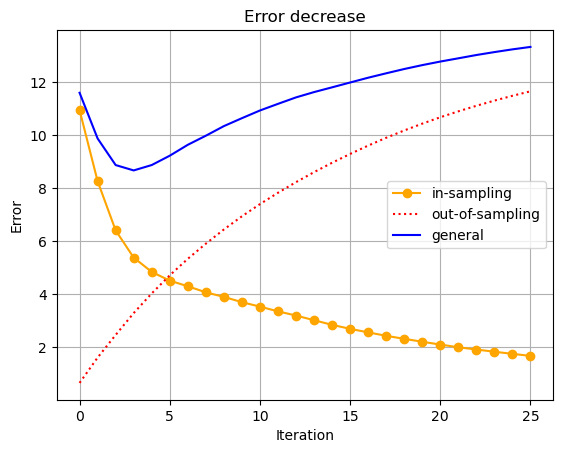

In [10]:
relErrorPlot(rel_errors)

In [11]:
rel_errors = np.array(rel_errors)

In [12]:
is_errs = rel_errors[:,0]
os_errs = rel_errors[:,1]
g_errs = rel_errors[:,2]

In [13]:
rank = np.array(rank_arr)

In [14]:
iters = np.linspace(1,len(rank),len(rank))

In [15]:
import pandas as pd

# Create a DataFrame
data = {
    "iterations": iters,
    "rank": rank,
    "insampling_error": is_errs,
    "outofsampling_error": os_errs,
    "general_error": g_errs
}
df = pd.DataFrame(data)

# Save to CSV
df.to_csv("SVT_tau1(max(n,m))_QTOFn100000xm1600.csv", index=False)



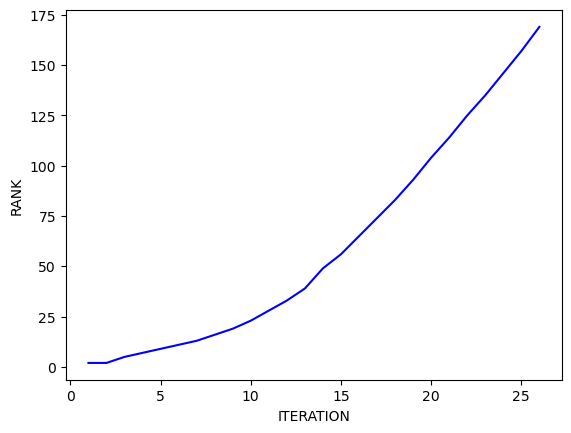

In [16]:
import matplotlib.pyplot as plt

# Plot the values
plt.plot(iters, rank, linestyle='-', color='b', label='Values')

# Add labels and title
plt.xlabel('ITERATION')
plt.ylabel('RANK')

# Display the plot
plt.show()


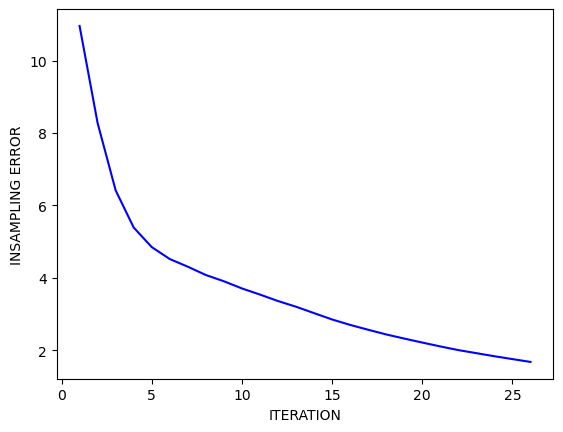

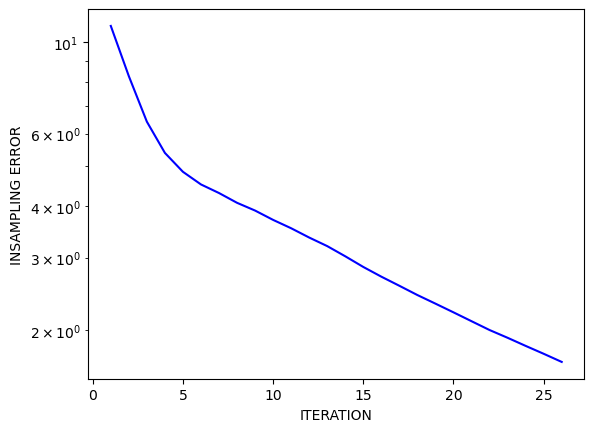

In [17]:
# Plot the values
plt.plot(iters, is_errs, linestyle='-', color='b', label='Values')

# Add labels and title
plt.xlabel('ITERATION')
plt.ylabel('INSAMPLING ERROR')
# plt.yscale('log')

# Display the plot
plt.show()

# Plot the values
plt.plot(iters, is_errs, linestyle='-', color='b', label='Values')

# Add labels and title
plt.xlabel('ITERATION')
plt.ylabel('INSAMPLING ERROR')
plt.yscale('log')

# Display the plot
plt.show()

In [19]:
import numpy as np

# Importing data from a CSV file
data = np.loadtxt('SVT_tau1(max(n,m))_QTOFn100000xm1600.csv', delimiter=',', skiprows=1)


# "iterations": iters,
# "rank": rank,
# "insampling_error": is_errs,
# "outofsampling_error": os_errs,
# "general_error": g_errs
# Separate columns into individual NumPy arrays
iters = data[:, 0]
rank = data[:, 1]
is_errs = data[:, 2]
os_errs = data[:, 3]
g_errs = data[:, 4]



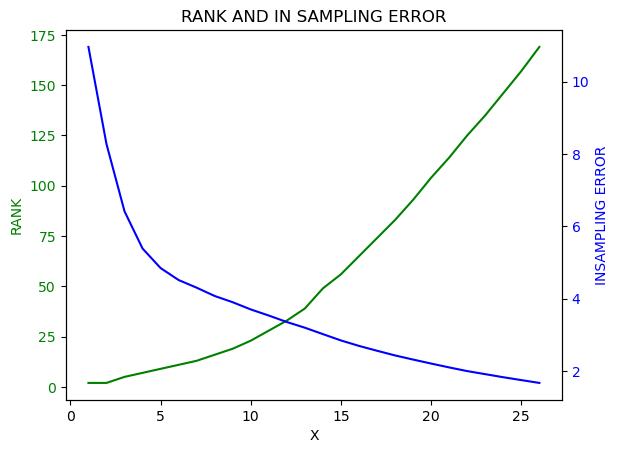

In [21]:
import matplotlib.pyplot as plt

# Example data
x = iters
y1 = rank  # First y-axis data
y2 = is_errs     # Second y-axis data

# Create the figure and axis
fig, ax1 = plt.subplots()

# Plot on the first y-axis
ax1.plot(x, y1, 'g-', label='RANK')  # Green line for y1
ax1.set_xlabel('X')
ax1.set_ylabel('RANK', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Create the second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis
ax2.plot(x, y2, 'b-', label='INSAMPLING ERROR')  # Blue line for y2
ax2.set_ylabel('INSAMPLING ERROR', color='b')
ax2.tick_params(axis='y', labelcolor='b')
# ax2.set_yscale('log')
# Title and show plot
plt.title('RANK AND IN SAMPLING ERROR')
plt.show()
